# Coloring Mapper outputs for all variables

* Ecological time periods (5 levels)
* Pool (6 levels)
* Stratum (5 main levels, but 8 levels total)
* Season (4 levels)
* Continuous variables (will have to choose a few from the 10)


### Metadata for each variable

**Ecological time periods**
These time periods are determined by the scientists because of events that happened.
* 1993-2000 
* 1998-2004
* 2001-2013
* 2010-2016
* 2014-2020

**Field number** (Pool)
Numeric code identifying the field station number. Listed below are the valid codes and their corresponding field station.

1 = Lake City, MN; 2 = Onalaska, WI; 3 = Bellevue, IA; 4 = Brighton, IL; 5 = Jackson, MO; 6 = Havana, IL

* 1 (Lake City, MN) is Pool 4
* 2 (Onalaska, WI) is Pool xx
* 3 (Bellevue, IA) is Pool xx
* 4 (Brighton, IL) is Pool xx
* 5 (Jackson, MO) is Pool xx
* 6 (Havana, IL) is Pool xx

**Stratum**
Aquatic area/Land use description code for the collection site.
Valid codes are as follows:
* 1 = Main channel
* 2 = Side channel
* 3 = Backwater area contiguous to the main channel
* 4 = Lake Pepin or Swan Lake
* The remaining strata can probably be grouped together as one
    * 5 = Impounded
    * 6 = Isolated
    * 7 = New Terrestrial
    * 9 = Unexploded Ordinance Area - Pool 13

**Season**
* 1 = Spring (March, April, May)
* 2 = Summer (June, July, August)
* 3 = Fall (September, October, November)
* 4 = Winter (December, January, February) 

**Continuous variables**
There are 10 total. We will use the $3 \times \text{IQR}$ definition of outliers to push down the ceiling for when we color for ease of interpretability.

* WDP
* SECCHI
* TEMP
* DO
* TURB
* VEL
* TP
* TN
* SS
* CHLcal

# Colors

There are four catgorical variables with various number of levels. For each categorical variable, each level will have an assigned color. This is because coloring the Mapper outputs can only give information on one level at a time. (As in, coloring the Mapper output gives information on one level of one variable at a time). 

I use the package [Palettable](https://jiffyclub.github.io/palettable/) to find categorical palettes.

In [1]:
from palettable.cartocolors.qualitative import Safe_4, Bold_6
# season, field number or stratum

from palettable.cartocolors.sequential import BluYl_7

from palettable.cartocolors.diverging import Temps_6

from palettable.cmocean.sequential import Thermal_10

from palettable.scientific.sequential import Batlow_10

In [2]:
Safe_4.colors
Safe_4.get_mpl_colormap() # seasons

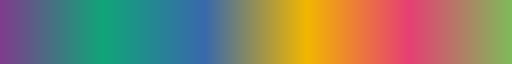

In [3]:
Bold_6.get_mpl_colormap() # field number

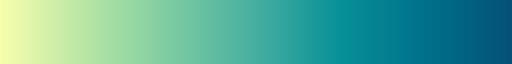

In [4]:
BluYl_7.get_mpl_colormap() # eco time periods -- change later

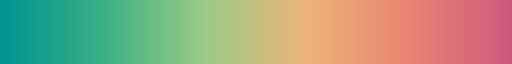

In [5]:
Temps_6.get_mpl_colormap() # stratum

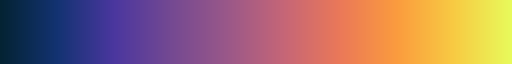

In [6]:
Thermal_10.get_mpl_colormap()

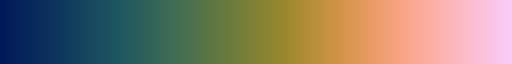

In [7]:
Batlow_10.get_mpl_colormap()



# Load other libraries

In [3]:
import kmapper as km
# import sklearn

import random

from sklearn.cluster import DBSCAN # clustering algorithm
from sklearn.decomposition import PCA # projection (lens) creation
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

# from sklearn import ensemble
# from sklearn.manifold import MDS

import plotly.graph_objs as go
# from ipywidgets import interactive, HBox, VBox, widgets, interact # ?
# import dash_html_components as html # ?
# import dash_core_components as dcc # ?

from kmapper.plotlyviz import * # static and interactive plots
import psutil # for plotlyviz
import kaleido # for plotlyviz
# import networkx # ?

# import dash # ?
import warnings #? 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import igraph
import cairocffi
print(igraph.__version__)

0.9.4


# Define functions for plotting

In [4]:
def mapper_pca2_db(df, DBSCAN_EPSILON = 10, DBSCAN_MIN_SAMPLES = 20,
                   N_CUBES = [10,10], PERC_OVERLAP = [.25,.25], return_with_df = False, print_pca_info = False):
    """
    return the scomplex from mapper.map using the clustering and mapper algorithms
    mapper.map uses only 10 continuous variables
    filter function is projecting onto pca2
    """
    
    df.reset_index(drop = True, inplace = True)
    
    X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB",
            "VEL", "TP", "TN", "SS", "CHLcal"]]
     
    # for discerning primary variables in PCA 
    continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                            "VEL", "TP", "TN", "SS", "CHLcal"]
    
    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in projected_vars]
    
    
    # create instance of clustering alg
    cluster_alg = DBSCAN(eps = DBSCAN_EPSILON, min_samples = DBSCAN_MIN_SAMPLES, 
                         metric='euclidean')

    # instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)
    
    if print_pca_info: 
        for j in range(2):
            pc_j = pca.components_[j]
            largest_magnitude = max(abs(pc_j))
            idx_magnitude = np.where(abs(pc_j) == largest_magnitude)[0][0]

            print("*** PCA", j+1, " ***")
            print("Primary variable: ", continuous_variables[idx_magnitude])
            print("Corresponding component: ", pc_j[idx_magnitude])
            print("Explained variance: ", pca.explained_variance_ratio_[j])
    
    summary_variable = mapper.project(np.array(X), projection=projected_var_indices, scaler=None)
    # similar to fit transform
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, 
                          cover=km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                          clusterer = cluster_alg)
    
    if return_with_df: 
        return(scomplex, df)

    return(scomplex)

In [5]:
def get_mapper_by_var(scomplex, df, var_lst, median_bool = False, max_bool = False):
    """
    1. iterates through each variable in var_lst
    2. calls get_mapper_graph on scomplex; color values supplied by variable
    3. adds custom tooltips from the variable (this is for the plotly dashboard)
    4. returns a list of kmgraph, mapper_summary, and colorf_distribution corresponding to each level in the var_lst
    
    params
    * scomplex is first return from mapper_pca2_db
    * df is second return from mapper_pca2_db
    * var_lst is a list str of the levels of a categorical variable. each variable in
      var_lst must be an existing COLUMNS OF df (one hot encoding). 
      for example, seasons_var_lst could be ['Spring', 'Summer', 'Fall', 'Winter']
    """
    
    km_lst = []
    summary_lst = []
    colors_lst = []
    
    if median_bool: 
        node_color_func = "median"
    elif max_bool:
        node_color_func = "max"
    else:
        node_color_func = "mean"
        
    print("The node color function is ", node_color_func)

    for var in var_lst:

        kmgraph, mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                       color_values = df[var],
                                                                       color_function_name = var,
                                                                        node_color_function = node_color_func)

        for node in kmgraph['nodes']:

            node['custom_tooltips'] = np.array(df[var])[scomplex['nodes'][node['name']]]
            # scomplex['nodes'] is a dictionary with keys that are the mapper nodes like cube600_cluster1, cube5_cluster0, etc....
            # [node['name']] is the name of the mapper node (such as cube600_cluster1)
            # scomplex['nodes'][node['name']] is a list of row numbers
            # that correspond with X

        km_lst.append(kmgraph)
        summary_lst.append(mapper_summary)
        colors_lst.append(colorf_distribution)

    return(km_lst, summary_lst, colors_lst)
        


In [6]:
def fixed_fr_plotly_graph(
    kmgraph,
    layout_from_igraph, # this is new
    colorscale=None,
    showscale=True,
    factor_size=11,
    edge_linecolor="rgb(180,180,180)",
    edge_linewidth=2.5,
    node_linecolor="rgb(180,180,180)",
    node_linewidth=2.5,
):
    """
    returns a network graph in the plotly format using the layout_from_igraph
    
    params
    * kmgraph is an element from the first return (list) of get_mapper_by_var
    * layout_from_igraph is from layt = G.layout("fr", niter = 1234)
    * colorscale ...
    
    """
    
    hover_text = [node["name"] for node in kmgraph["nodes"]]
    color_vals = [node["color"] for node in kmgraph["nodes"]]
    node_size = np.array(
        [factor_size * node["size"] for node in kmgraph["nodes"]], dtype=np.int
    )
    
    N = len(layt)
    Xnodes = [layout_from_igraph[k][0] for k in range(N)]  # x-coordinates of nodes
    Ynodes = [layout_from_igraph[k][1] for k in range(N)]  # y-coordnates of nodes

    Xedges = []
    Yedges = []
    for e in links:
        Xedges.extend([layout_from_igraph[e[0]][0], 
                       layout_from_igraph[e[1]][0], None])
        Yedges.extend([layout_from_igraph[e[0]][1], 
                       layout_from_igraph[e[1]][1], None])

    Xn = Xnodes
    Yn = Ynodes
    Xe = Xedges
    Ye = Yedges

    edge_trace = dict(
        type="scatter",
        x=Xe,
        y=Ye,
        mode="lines",
        line=dict(color=edge_linecolor, width=edge_linewidth),
        hoverinfo="none",
    )

    node_trace = dict(
        type="scatter",
        x=Xn,
        y=Yn,
        mode="markers",
        marker=dict(
            size=node_size.tolist(),
            color=color_vals,
            opacity=1.0,
            colorscale=colorscale,
            showscale=True,
            line=dict(color=node_linecolor, width=node_linewidth),
            colorbar=dict(thickness=10, ticklen=4, x=1.01, tickfont=dict(size=10)),
        ),
        text=hover_text,
        hoverinfo="text",
    )
    
    return([edge_trace, node_trace])

In [7]:
def save_plotly(km_lst, summary_lst, color_lst, palette_lst, var_lst, layout_from_igraph):
    """
    save to working directory static graphs.
    return a list of plotly objects that can be shown in jupyter notebook. 
    """
    
    plotly_lst = []

    for var_idx in range(len(var_lst)):
        
        graph_data = fixed_fr_plotly_graph(kmgraph = km_lst[var_idx], layout_from_igraph = layt, 
                                           colorscale = palette_lst[var_idx])
        
        layout = plot_layout(title = var_lst[var_idx], # maybe change?
                         width = 1200, height = 1200,
                         annotation_text=get_kmgraph_meta(summary_lst[var_idx]))

        fw_graph = go.FigureWidget(data = graph_data, layout=layout)

        fw_hist = node_hist_fig(color_lst[var_idx])
        fw_summary = summary_fig(summary_lst[var_idx], height=300)
        dashboard = hovering_widgets(km_lst[var_idx],
                                     fw_graph,
                                     ctooltips=True, # ctooltips = True, because we assigned a label to each
                                                     #cluster member
                                     member_textbox_width=600)

        # Update the fw_graph colorbar, setting its title:

        fw_graph.data[1].marker.colorbar.title = "Percent"

        # save the graph without the dashboard
        fw_graph.write_image(var_lst[var_idx] + ".png", width = 1600, height = 1600) 

        plotly_lst.append(dashboard)
        
    return(plotly_lst)

# Run TDA, retrieve the scomplex

In [15]:
water20 = pd.read_csv("../LTRM data/RF interpolation/water_full.csv")

water20['wrong_long'] = water20['LONGITUDE']
water20['LONGITUDE'] = water20['LATITUDE']
water20['LATITUDE'] = water20['wrong_long'] # coding error - switch lat and lng


water_df = water20[["WDP", "SECCHI", "TEMP", "DO", "TURB",
                    "VEL", "TP", "TN", "SS", "CHLcal",
                    "YEAR", "SEASON", "FLDNUM", "STRATUM", 
                    "SHEETBAR", "DATE", "LATITUDE", "LONGITUDE"]]

ct = ColumnTransformer([
        ('somename', RobustScaler(), ["WDP", "SECCHI", "TEMP", "DO", "TURB",
                                        "VEL", "TP", "TN", "SS", "CHLcal"])
    ], remainder='passthrough')

water_df = pd.DataFrame(ct.fit_transform(water_df), columns = ["WDP", "SECCHI", "TEMP", "DO", "TURB",
                                                               "VEL", "TP", "TN", "SS", "CHLcal",
                                                               "YEAR", "SEASON", "FLDNUM", "STRATUM", 
                                                               "SHEETBAR", "DATE", "LATITUDE", "LONGITUDE"])

water_df = water_df.replace({'SEASON': {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}})

water_df.head()

,WDP,SECCHI,TEMP,DO,TURB,VEL,TP,TN,SS,CHLcal,YEAR,SEASON,FLDNUM,STRATUM,SHEETBAR,DATE,LATITUDE,LONGITUDE
0,-0.018088,-0.046512,0.572414,-0.72093,0.210526,0.576923,0.481481,0.918033,0.361752,-0.294693,1993,Summer,"Lake City, MN",Main channel,41000065,07/26/1993,-92.51097,44.571864
1,1.5323,0.0,0.572414,-0.72093,0.210526,1.0,0.488889,1.547131,0.262323,-0.342123,1993,Summer,"Lake City, MN",Main channel,41000066,07/26/1993,-92.518497,44.575497
2,0.524548,0.023256,0.565517,-0.790698,0.105263,0.884615,0.422222,0.918033,0.18828,-0.323151,1993,Summer,"Lake City, MN",Main channel,41000067,07/26/1993,-92.523549,44.573718
3,1.764858,-0.093023,0.565517,-0.767442,0.210526,0.942308,0.362963,1.124317,0.173472,-0.332637,1993,Summer,"Lake City, MN",Main channel,41000068,07/26/1993,-92.541238,44.566588
4,1.144703,0.069767,0.572414,-0.72093,0.342105,0.923077,0.548148,0.969262,0.482336,-0.291531,1993,Summer,"Lake City, MN",Main channel,41000069,07/26/1993,-92.54878,44.568419


In [16]:
scomplex, water_df = mapper_pca2_db(water_df, DBSCAN_EPSILON = 1, DBSCAN_MIN_SAMPLES = 20,
                                        N_CUBES = [125,125], PERC_OVERLAP = [0.4,0.4], 
                                        return_with_df = True, print_pca_info = False)

# Initialize layout_from_igraph

I use the `eco_time_periods` as an arbitrary start. These are the time periods set by ecologists as important for the river. 

In [17]:
eco_time_periods = ['1993-2000', '1998-2004', '2001-2013', '2010-2016', '2014-2020']

# add dummy columns for time periods
for time_period in eco_time_periods:
    begin_year = int(time_period[0:4])
    end_year = int(time_period[5:9])
    
    water_df[time_period] = np.where((water_df['YEAR'] >= begin_year) & (water_df['YEAR'] <= end_year), 1, 0)

In [18]:
# set up igraph_layout

eco_km, eco_summary, eco_colors = get_mapper_by_var(scomplex, water_df, eco_time_periods)

kmgraph = eco_km[0]
   

The node color function is  mean


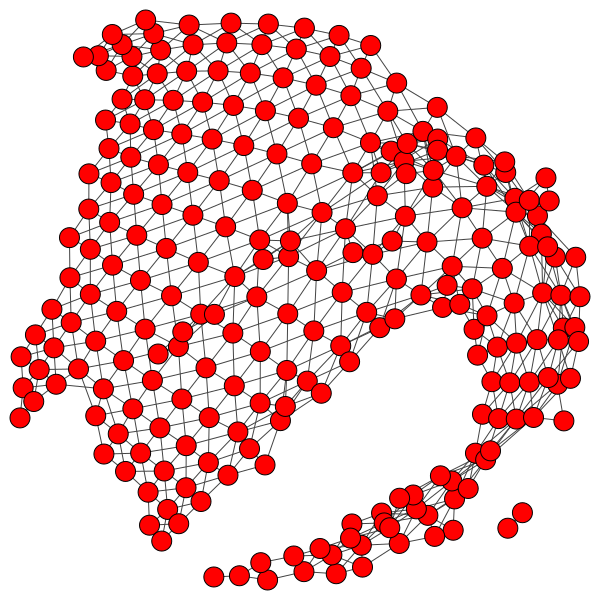

In [23]:
random.seed(1)

n_nodes = len(kmgraph["nodes"])
if n_nodes == 0:
    raise ValueError("Your graph has 0 nodes")
G = igraph.Graph(n=n_nodes)
links = [(e["source"], e["target"]) for e in kmgraph["links"]]
G.add_edges(links)
layt = G.layout("fr", niter = 900)

igraph.plot(G, layout=layt) 

So this layout will be the universal layout for all our plots. Now it's just time to add color! I continue on the ecological time periods.

# Color by levels of categorical variables

## Ecological time periods

Starting with the 5 level ecological time periods.

In [25]:
eco_palette = []
interval = 1/(len(BluYl_7.colors)-1)
# print(interval)

# create palette so that Kepler Mapper can read it
for color_idx in range(len(BluYl_7.colors)): # 5 levels in ecological time periods
    color = BluYl_7.colors[color_idx]
    
    length = len(str(color))
    
    color_str = "rgb(" + str(color)[1:length-1] + ")"
    # print(color_str)
    
    color_swatch = [interval*color_idx, color_str]
    
    eco_palette.append(color_swatch)


eco_palettes = []

# create list of palettes for save_plotly()
for time_period in eco_time_periods:
    eco_palettes.append(eco_palette)

In [16]:
#     if not colorscale:
#         colorscale = [
#         [0.0, "rgb(68, 1, 84)"],  # Viridis
#         [0.1, "rgb(72, 35, 116)"],
#         [0.2, "rgb(64, 67, 135)"],
#         [0.3, "rgb(52, 94, 141)"],
#         [0.4, "rgb(41, 120, 142)"],
#         [0.5, "rgb(32, 144, 140)"],
#         [0.6, "rgb(34, 167, 132)"],
#         [0.7, "rgb(68, 190, 112)"],
#         [0.8, "rgb(121, 209, 81)"],
#         [0.9, "rgb(189, 222, 38)"],
#         [1.0, "rgb(253, 231, 36)"],
#     ]
        

In [26]:
eco_plotly = save_plotly(eco_km, eco_summary, eco_colors, eco_palettes, eco_time_periods, layt)


## Pools

In [27]:
pool_var = ["Lake City, MN", "Onalaska, WI", "Bellevue, IA", "Brighton, IL", "Jackson, MO",  "Havana, IL"]

# add dummy columns for season
for pool in pool_var:
    water_df[pool] = np.where((water_df["FLDNUM"] == pool), 1, 0)

In [28]:
water_df[pool_var].head()

,"Lake City, MN","Onalaska, WI","Bellevue, IA","Brighton, IL","Jackson, MO","Havana, IL"
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [29]:

pool_palettes = []

# print(interval)

for pool_idx in range(len(pool_var)): # 5 levels in ecological time periods
    color = Bold_6.colors[1]
    
    length = len(str(color))
    
    color_str = "rgb(" + str(color)[1:length-1] + ")"
    # print(color_str)
        
    pool_palette = [[0.0, "rgb(255,255,255)"],
                    [1.0, color_str]]
    
    pool_palettes.append(pool_palette)



In [30]:
pool_km, pool_summary, pool_colors = get_mapper_by_var(scomplex, water_df, pool_var)

The node color function is  mean


In [31]:
pool_plotly = save_plotly(pool_km, pool_summary, pool_colors, pool_palettes, pool_var, layt)

In [59]:
pool_plotly[0]

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [23]:
print(pool_palettes)

[[[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(127, 60, 141)']], [[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(17, 165, 121)']], [[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(57, 105, 172)']], [[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(242, 183, 1)']], [[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(231, 63, 116)']], [[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(128, 186, 90)']]]


## Season

In [32]:
season_var = ["Spring", "Summer", "Fall", "Winter"]

# add dummyy columns for season
for season in season_var:
    water_df[season] = np.where((water_df[["SEASON"]] == season), 1, 0)

In [33]:
mysafe_4 = Safe_4.colors[1:4]
mysafe_4.append(Safe_4.colors[0])

In [34]:
season_palettes = []

# print(interval)

for season_idx in range(len(season_var)): # 5 levels in ecological time periods
    color = mysafe_4[season_idx]
    
    length = len(str(color))
    
    color_str = "rgb(" + str(color)[1:length-1] + ")"
    # print(color_str)
        
    season_palette = [[0.0, "rgb(255,255,255)"],
                    [1.0, color_str]]
    
    season_palettes.append(season_palette)



In [35]:
season_km, season_summary, season_colors = get_mapper_by_var(scomplex, water_df, season_var)

The node color function is  mean


In [36]:
season_plotly = save_plotly(season_km, season_summary, season_colors, season_palettes, season_var, layt)

# Color by continuous variables

This one requires scaling the outliers down to the $\text{median} + \left( 3 \times \text{IQR} \right)$ so that the color scaling is reasonable. So I have to play around with `water_df` a little bit. This is from Alaina's code.

In [37]:
continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
plot_cont = []
cont_palettes = []

In [283]:
palette = [[0.0, "rgb(68, 1, 84)"],  # Viridis
           [0.1, "rgb(72, 35, 116)"],
           [0.2, "rgb(64, 67, 135)"],
           [0.3, "rgb(52, 94, 141)"],
           [0.4, "rgb(41, 120, 142)"],
           [0.5, "rgb(32, 144, 140)"],
           [0.6, "rgb(34, 167, 132)"],
           [0.7, "rgb(68, 190, 112)"],
           [0.8, "rgb(121, 209, 81)"],
           [0.9, "rgb(189, 222, 38)"],
           [1.0, "rgb(253, 231, 36)"]]

for variable in continuous_variables:
    column_name =  variable + "_COLOR" 
    
    plot_cont.append(column_name)

    q25, q75 = np.percentile(water_df[variable], [25, 75])
    iqr = q75 - q25

    ceiling = water_df[variable].quantile(.75) + (3 * iqr)

    water_df[column_name] = np.where(water_df[variable] >= ceiling, ceiling, water_df[variable])
    
    cont_palettes.append(palette)
    

In [31]:
cont_km, cont_summary, cont_colors = get_mapper_by_var(scomplex, water_df, plot_cont)

In [32]:
cont_plotly = save_plotly(cont_km, cont_summary, cont_colors, cont_palettes, plot_cont, layt)

# Poster visualizations: global (entire LTRM)

So I use the dataframe and scomplex objects that Alaina already ran. This saves some time. I jump from the section **Initialize Graph Layout** to here. I use `STATE_color` to color by state (there are multiple state columns). 

In [38]:
import pickle as pk
import json as js

In [227]:
# dataFilePath = "../pools_specific_EDA/Upper Pool 4/LTRM TDA/tda scripts/LTRM_df.p"
# water_df = pk.load(open(dataFilePath, "rb"))['LTRM']

# dataFilePath = "../pools_specific_EDA/Upper Pool 4/LTRM TDA/tda scripts/LTRM_scomplex.p"
# scomplex = pk.load(open(dataFilePath, "rb"))['LTRM']

In [39]:
water_df.head()

,WDP,SECCHI,TEMP,DO,TURB,VEL,TP,TN,SS,CHLcal,...,"Lake City, MN","Onalaska, WI","Bellevue, IA","Brighton, IL","Jackson, MO","Havana, IL",Spring,Summer,Fall,Winter
0,-0.018088,-0.046512,0.572414,-0.72093,0.210526,0.576923,0.481481,0.918033,0.361752,-0.294693,...,1,0,0,0,0,0,0,1,0,0
1,1.5323,0.0,0.572414,-0.72093,0.210526,1.0,0.488889,1.547131,0.262323,-0.342123,...,1,0,0,0,0,0,0,1,0,0
2,0.524548,0.023256,0.565517,-0.790698,0.105263,0.884615,0.422222,0.918033,0.18828,-0.323151,...,1,0,0,0,0,0,0,1,0,0
3,1.764858,-0.093023,0.565517,-0.767442,0.210526,0.942308,0.362963,1.124317,0.173472,-0.332637,...,1,0,0,0,0,0,0,1,0,0
4,1.144703,0.069767,0.572414,-0.72093,0.342105,0.923077,0.548148,0.969262,0.482336,-0.291531,...,1,0,0,0,0,0,0,1,0,0


In [23]:
waterstate_scomplex.keys()

dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes', 'density', 'graph', 'maxima', 'states'])

# Global poster viz: Pools

In [40]:
pool_var = ["Lake City, MN", "Onalaska, WI", "Bellevue, IA", "Brighton, IL", "Jackson, MO",  "Havana, IL"]

# add dummyy columns for season
for pool in pool_var:
    water_df[pool] = np.where((water_df["FLDNUM"] == pool), 1, 0)

In [28]:
water_df[pool_var].head()

,"Lake City, MN","Onalaska, WI","Bellevue, IA","Brighton, IL","Jackson, MO","Havana, IL"
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [45]:

pool_palettes = []

# print(interval)

for pool_idx in range(len(pool_var)): # 5 levels in ecological time periods
    color = Bold_6.colors[pool_idx]
    
    length = len(str(color))
    
    color_str = "rgb(" + str(color)[1:length-1] + ")"
    # print(color_str)
        
    pool_palette = [[0.0, "rgb(255,255,255)"],
                    [1.0, color_str]]
    
    pool_palettes.append(pool_palette)



In [46]:
pool_km, pool_summary, pool_colors = get_mapper_by_var(scomplex, water_df, pool_var)

In [47]:
pool_plotly = save_plotly(pool_km, pool_summary, pool_colors, pool_palettes, pool_var, layt)

# Global poster viz: Continuous variables (unscaled, with the ceiling of 3*IQR)

This one requires scaling the outliers down to the $\text{median} + \left( 3 \times \text{IQR} \right)$ so that the color scaling is reasonable. So I have to play around with `water_df` a little bit. This is from Alaina's code.

In [240]:
continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
plot_cont = []
cont_palettes = []

In [245]:
palette = [
    [0.0, "rgb(68, 1, 84)"],  # Viridis
    [0.1, "rgb(72, 35, 116)"],
    [0.2, "rgb(64, 67, 135)"],
    [0.3, "rgb(52, 94, 141)"],
    [0.4, "rgb(41, 120, 142)"],
    [0.5, "rgb(32, 144, 140)"],
    [0.6, "rgb(34, 167, 132)"],
    [0.7, "rgb(68, 190, 112)"],
    [0.8, "rgb(121, 209, 81)"],
    [0.9, "rgb(189, 222, 38)"],
    [1.0, "rgb(253, 231, 36)"],
]

for variable in continuous_variables:
    
    column_name =  variable + "_COLOR" 
    
    plot_cont.append(column_name)

    q25, q75 = np.percentile(water_df[variable], [25, 75])
    iqr = q75 - q25

    ceiling = water_df[variable].quantile(.75) + (3 * iqr)

    water_df[column_name] = np.where(water_df[variable] >= ceiling, ceiling, water_df[variable])
    
    cont_palettes.append(palette)
    

In [243]:
cont_km, cont_summary, cont_colors = get_mapper_by_var(scomplex, water_df, plot_cont)

mean


In [244]:
cont_plotly = save_plotly(cont_km, cont_summary, cont_colors, cont_palettes, plot_cont, layt)

# Global poster viz: States

In [41]:
myTemps = Temps_6.colors
myTemps = myTemps[2:6]

states_palette = []

interval = 1/(len(myTemps)-1)
# print(interval)

for color_idx in range(len(myTemps)): # 5 levels in ecological time periods
    color = myTemps[color_idx]
    
    length = len(str(color))
    
    color_str = "rgb(" + str(color)[1:length-1] + ")"
    # print(color_str)
    
    color_swatch = [interval*color_idx, color_str]
    
    states_palette.append(color_swatch)


In [42]:
state_km, state_summary, state_colors = get_mapper_by_var(scomplex, waterstate_df, ['STATE_color'], True)

In [43]:
state_plotly = save_plotly(state_km, state_summary, state_colors, [palette], ['STATE_color'], layt)

# Pool 4 Specific Visualizations

In [41]:
dataFilePath = "../pools_specific_EDA/Upper Pool 4/LTRM TDA/Pool4_splt_df.p"
pool4_df = pk.load(open(dataFilePath, "rb"))['Pool4_splt_df']

dataFilePath = "../pools_specific_EDA/Upper Pool 4/LTRM TDA/Pool4_splt_scomplex.p"
pool4_scomplex = pk.load(open(dataFilePath, "rb"))['Pool4_splt_scomplex']

# use the pickle files that Alaina prepared

In [42]:
pool4_df = pool4_df.rename(columns={"WDP_color": "WDP_COLOR",
                                    "SECCHI_color": "SECCHI_COLOR", 
                                    "TEMP_color": "TEMP_COLOR", 
                                    "DO_color": "DO_COLOR", 
                                    "TURB_color": "TURB_COLOR", 
                                    "VEL_color": "VEL_COLOR", 
                                    "TP_color": "TP_COLOR", 
                                    "TN_color": "TN_COLOR", 
                                    "SS_color": "SS_COLOR", 
                                    "CHLcal_color": "CHLcal_COLOR", 
                                    "LATTITUDE": "LATITUDE"})

In [43]:
pool4_df.head()

,WDP,SECCHI,TEMP,DO,TURB,VEL,TP,TN,SS,CHLcal,...,DO_COLOR,TURB_COLOR,VEL_COLOR,TP_COLOR,TN_COLOR,SS_COLOR,CHLcal_COLOR,State 1,State 2,STATE
0,-0.018088,-0.046512,0.572414,-0.72093,0.210526,0.576923,0.481481,0.918033,0.361752,-0.294693,...,-0.72093,0.210526,0.576923,0.481481,0.918033,0.361752,-0.294693,1,0,0.5
1,1.5323,0.0,0.572414,-0.72093,0.210526,1.0,0.488889,1.547131,0.262323,-0.342123,...,-0.72093,0.210526,1.0,0.488889,1.547131,0.262323,-0.342123,1,0,0.5
2,0.524548,0.023256,0.565517,-0.790698,0.105263,0.884615,0.422222,0.918033,0.18828,-0.323151,...,-0.790698,0.105263,0.884615,0.422222,0.918033,0.18828,-0.323151,1,0,0.5
3,1.764858,-0.093023,0.565517,-0.767442,0.210526,0.942308,0.362963,1.124317,0.173472,-0.332637,...,-0.767442,0.210526,0.942308,0.362963,1.124317,0.173472,-0.332637,1,0,0.5
4,1.144703,0.069767,0.572414,-0.72093,0.342105,0.923077,0.548148,0.969262,0.482336,-0.291531,...,-0.72093,0.342105,0.923077,0.548148,0.969262,0.482336,-0.291531,1,0,0.5


In [44]:
pool4_df.columns.values

array(['WDP', 'SECCHI', 'TEMP', 'DO', 'TURB', 'VEL', 'TP', 'TN', 'SS',
       'CHLcal', 'SHEETBAR', 'DATE', 'LATITUDE', 'LONGITUDE', 'FLDNUM',
       'STRATUM', 'LOCATCD', 'YEAR', 'SEASON', '1993-2000', '1898-2004',
       '2001-2013', '2010-2016', '2014-2020',
       'Backwater area contiguous to the main channel', 'Impounded',
       'Isolated', 'Lake Pepin or Swan Lake', 'Main channel',
       'Side channel', 'Unexploded Ordinance Area - Pool 13', 'UPPER',
       'LOWER', 'WDP_COLOR', 'SECCHI_COLOR', 'TEMP_COLOR', 'DO_COLOR',
       'TURB_COLOR', 'VEL_COLOR', 'TP_COLOR', 'TN_COLOR', 'SS_COLOR',
       'CHLcal_COLOR', 'State 1', 'State 2', 'STATE'], dtype=object)

In [185]:
pool4_scomplex.keys()

dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes', 'density', 'graph', 'maxima', 'states'])

## Pool 4 viz: Continuous variables

In [284]:
plot_cont

['WDP_COLOR',
 'SECCHI_COLOR',
 'TEMP_COLOR',
 'DO_COLOR',
 'TURB_COLOR',
 'VEL_COLOR',
 'TP_COLOR',
 'TN_COLOR',
 'SS_COLOR',
 'CHLcal_COLOR']

In [45]:
interval = 1 / len(Thermal_10.colors)

pool4_palette = []

for color_idx in range(len(Thermal_10.colors)):
    
    color = str(Thermal_10.colors[color_idx])
    pool4_palette.append([color_idx*interval, "rgb(" + color[1:len(color)-1] + ")"])

pool4_palettes = []

for var in continuous_variables:
    pool4_palettes.append(pool4_palette)
    
pool4_palette

[[0.0, 'rgb(4, 35, 51)'],
 [0.1, 'rgb(19, 51, 114)'],
 [0.2, 'rgb(75, 55, 159)'],
 [0.30000000000000004, 'rgb(116, 73, 146)'],
 [0.4, 'rgb(154, 88, 137)'],
 [0.5, 'rgb(198, 102, 119)'],
 [0.6000000000000001, 'rgb(235, 121, 88)'],
 [0.7000000000000001, 'rgb(251, 156, 62)'],
 [0.8, 'rgb(248, 203, 67)'],
 [0.9, 'rgb(232, 250, 91)']]

In [261]:
palette

[[0.0, 'rgb(68, 1, 84)'],
 [0.1, 'rgb(72, 35, 116)'],
 [0.2, 'rgb(64, 67, 135)'],
 [0.3, 'rgb(52, 94, 141)'],
 [0.4, 'rgb(41, 120, 142)'],
 [0.5, 'rgb(32, 144, 140)'],
 [0.6, 'rgb(34, 167, 132)'],
 [0.7, 'rgb(68, 190, 112)'],
 [0.8, 'rgb(121, 209, 81)'],
 [0.9, 'rgb(189, 222, 38)'],
 [1.0, 'rgb(253, 231, 36)']]

In [257]:
type(pool4_palettes[0][0][0])

float

In [47]:
cont_km, cont_summary, cont_colors = get_mapper_by_var(pool4_scomplex, pool4_df, continuous_variables)

The node color function is  mean


### Pool 4 Initialize layout

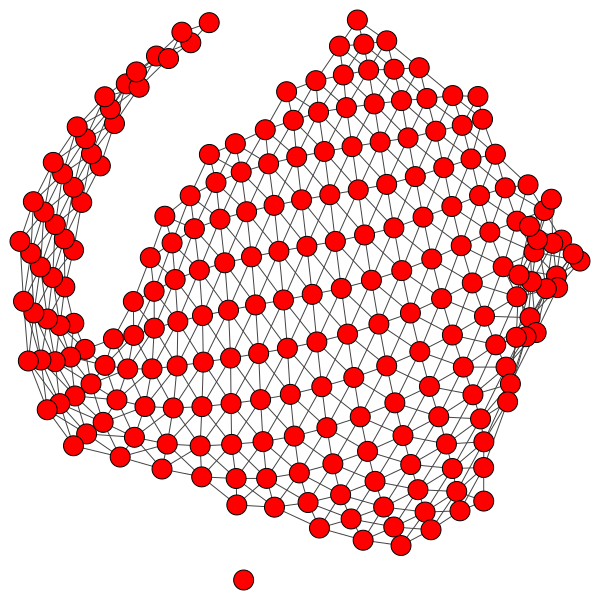

In [58]:
kmgraph = cont_km[0]

random.seed(9)

n_nodes = len(kmgraph["nodes"])
if n_nodes == 0:
    raise ValueError("Your graph has 0 nodes")
G = igraph.Graph(n=n_nodes)
links = [(e["source"], e["target"]) for e in kmgraph["links"]]
G.add_edges(links)
layt = G.layout("fr", niter = 100)

igraph.plot(G, layout=layt) 

In [291]:
cont_plotly = save_plotly(cont_km, cont_summary, cont_colors, pool4_palettes, plot_cont, layt)

ValueError: 
    Invalid value of type 'builtins.list' received for the 'colorscale' property of scatter.marker
        Received value: [0.0, 'rgb(4, 35, 51)']

    The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1),
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd'].
        Appending '_r' to a named colorscale reverses it.


## Pool 4 viz: States

Use median to color state

In [8]:
myTemps = Temps_6.colors
myTemps = myTemps[2:6]

states_palette = []

interval = 1/(len(myTemps)-1)
# print(interval)

for color_idx in range(len(myTemps)): # 5 levels in ecological time periods
    color = myTemps[color_idx]
    
    length = len(str(color))
    
    color_str = "rgb(" + str(color)[1:length-1] + ")"
    # print(color_str)
    
    color_swatch = [interval*color_idx, color_str]
    
    states_palette.append(color_swatch)


In [24]:
import pickle
out_tup = pickle.load(open(r"..\pools_specific_EDA\Pool 8\output_tuple.p",'rb'))
scomplex = out_tup[0]
df = out_tup[1]
df_scaled = out_tup[2]

In [31]:
scomplex.keys()

dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes'])

In [28]:
state_km, state_summary, state_colors = get_mapper_by_var(scomplex, df, ['STATE'], False, True)

The node color function is  max


KeyError: 'STATE'

In [347]:
state_palette = []

interval = 1 / (len(Thermal_10.colors)-3)

for color_idx in range(len(Thermal_10.colors)-2):
    
    color = str(Thermal_10.colors[color_idx])
    state_palette.append([color_idx*interval, "rgb(" + color[1:len(color)-1] + ")"])

state_palette

[[0.0, 'rgb(4, 35, 51)'],
 [0.14285714285714285, 'rgb(19, 51, 114)'],
 [0.2857142857142857, 'rgb(75, 55, 159)'],
 [0.42857142857142855, 'rgb(116, 73, 146)'],
 [0.5714285714285714, 'rgb(154, 88, 137)'],
 [0.7142857142857142, 'rgb(198, 102, 119)'],
 [0.8571428571428571, 'rgb(235, 121, 88)'],
 [1.0, 'rgb(251, 156, 62)']]

In [348]:
state_plotly = save_plotly(state_km, state_summary, state_colors, [state_palette], ['STATE'], layt)

## Pool 4 viz: Upper vs. lower (later)

In [170]:
pool4_df.shape

(9810, 48)

In [171]:
continuous_variables

['WDP', 'SECCHI', 'TEMP', 'DO', 'TURB', 'VEL', 'TP', 'TN', 'SS', 'CHLcal']

In [193]:
pool4_df['wrong_long'] = pool4_df['LONGITUDE']
pool4_df['LONGITUDE'] = pool4_df['LATITUDE']
pool4_df['LATITUDE'] = pool4_df['wrong_long'] # code error with lat / long

In [197]:
pool4_df["UPPER"] = np.where((pool4_df['LATITUDE'] <= -92.4) & 
                             (pool4_df['FLDNUM'] != 'Lake Pepin or Swan Lake'), 
                             1, 0)
pool4_df["LOWER"] = np.where((pool4_df['LATITUDE'] >= -92.2) & 
                             (pool4_df['FLDNUM'] != 'Lake Pepin or Swan Lake'),
                             1, 0)

In [198]:
region_km, region_summary, region_colors = get_mapper_by_var(pool4_scomplex, pool4_df, ['LOWER', 'UPPER'], 
                                                             False, False)

mean


In [199]:
region_plotly = save_plotly(region_km, region_summary, region_colors, pool_palettes, 
                            ['LOWER', 'UPPER'], layt)